Lost Deliveries Impact Model 
--

1. Use first 28 days to get features, label should be from the next 28 days.
2. 28 days should not use the same start and end day for different users, the first day of the 28 days is the first time we observe a session from the user, then 28 days from this day.
3. When using Lasso, the features need to be normalized.
4. A classifiction model first, churned vs active.

V2.2
  - Important analysis and insights
  - Clear users with no true lost delivery
  - Need to add control for visit: people visiting less naturally have a higher churn rate.
  - Zone difference is not obvious.
  - **The implicit churn rate and implicit lost_true_d_visit for customers with different visits is surprising.**
    - Definitely need to have 'visit' as control/feture. 
    
V3.0
  - Clear session when the user type is "New".
  
V4.0: Positive Result, 0.1 DeltaLd ~ -0.1 Visit
  - In V3.0:
    - user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit'] * 28
    - user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit'] * 28
  - Here:
    - user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit']
    - user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit']
  - Correct a bug caused by join user_zones.
  
V5.0
  - Do the following transformation for lost_estimate in not converted.
    - To 0.0025: 0, to 0.047: 1, to 0.0755: 2, to 0.1038: 3, others: 4.
    
V5.0.1
  - Same as V5.0, but use the following for training and testing data:
  ```
  data = df[(df['user_type'] == user_type_model)\
          & (df['lost_true_scale_d_visit'].notnull())]
  ```
  instead of 
  ```
  data = df[(df['user_type'] == user_type_model)\
          & (df['lost_estimate'] > 0)\
          & (df['lost_true'].notnull())]
  ```
  
V6.0
  - New segments analysis
  - Separate pre-checkout and checkout, only focus on one.
  - This one is focuse on checkout.
  
V6.0.0.1
  - Same as V6.0.
  - Use lost_true_d_visit.
  
V7.0
  - Copied V6.0.0.1.
  - Clean up all the unnecessary codes.

In [1]:
import pandas as pd
import numpy as np
import re
from matplotlib import pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
import statsmodels.api as sm
from datetime import datetime, timedelta
import pickle

%matplotlib inline

In [2]:
# File names
time_period = '20180903_20180930'

file1 = 'lds_orders_20180903_20180930.pkl'
file2 = 'lds_orders_20181001_20181028.pkl'
file3 = 'lds_orders_20181029_20181125.pkl'
file_user = 'user_info_20180903_20180930.pkl'
file_membership = 'subscription_info_20180903_20180930.pkl'

# Do not need to change for now.
file_zone = '20180903 Zone_Average_Deliveries.csv'

In [3]:
# Read in 28 days LDs and Orders

df_lds_orders_201809 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/'\
                                     + file1)

df_lds_orders_201810 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/'\
                                     + file2)

df_lds_orders_201811 = pd.read_pickle(\
    '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/'\
                                     + file3)

# Read in user infos for users in this 28 days
user_infos = pd.read_pickle(\
'/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/'\
                           + file_user)

# Read in zone average demand for the period.
df_zones = pd.read_csv('../../../data/' + file_zone)
df_zones.rename(columns={'ZONE_ID':'zone_id', 'DEMAND':'demand'}, inplace=True)

In [4]:
if True:

    df_membership = pd.read_pickle(\
        '/Users/jianhuitian/carrot/logistics/logistics-data-science/conversion_model_v1/lost_deliveries_v4/data/'\
                                  + file_membership)
    
    #df_membership['starts_on'] = df_membership['starts_on'].astype('str')
    #df_membership['ends_on'] = df_membership['ends_on'].astype('str')

    #df_membership['starts_on'] = df_membership['starts_on']\
    #    .map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
    #df_membership['ends_on'] = df_membership['ends_on']\
    #    .map(lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S').date())
    
    #start = datetime.strptime('2018-09-03', "%Y-%m-%d").date()
    #end = datetime.strptime('2018-10-28', "%Y-%m-%d").date()
    #df_membership.sort_values(by=['user_id', 'starts_on'], inplace=True)

## Functions, Variables, etc.

In [5]:
user_type_map = {'new': 1, 'non_express': 2, 'free_express': 3, 'discount_express': 4, 'paid_express': 5}
user_type_map_reverse = {v:k for k,v in user_type_map.items()}

def get_orders(df):
    # df[['user_id', 'date', 'converted']]
    
    orders_per_day = df[['user_id', 'date', 'converted']]\
        .groupby(['user_id', 'date']).sum().reset_index()

    orders = orders_per_day[orders_per_day['converted'] != 0][['user_id', 'date']]\
        .groupby(['user_id']).count().reset_index().rename(columns={'date': 'order'})
    
    return orders 

def get_visits(df):
    # df[['user_id', 'date']]
    
    unique_visits = df[['user_id', 'date']]\
        .drop_duplicates()

    visits = unique_visits.groupby(['user_id']).count().reset_index()\
        .rename(columns={'date':'visit'})
    
    return visits

def get_num_warehouse(df):
    # df[['user_id', 'warehouse_id']]
    
    num_warehouse = df[['user_id', 'warehouse_id']]\
        .drop_duplicates()
    
    num_warehouse = num_warehouse.groupby(['user_id']).count().reset_index()\
        .rename(columns={'warehouse_id':'num_warehouse'})
    
    return num_warehouse

## Get user ids for study.

In [6]:
# Get all the user_ids during "time_period".
# Get the corresponding first_date and last_date.
# The 28 days period is based on this first_date and last_date for each of the users.

user_ids = df_lds_orders_201809[['user_id', 'date']]\
    .groupby(['user_id']).min().reset_index()\
    .rename(columns={'date':'first_date'})
user_ids['last_date'] = user_ids['first_date'].map(lambda x: x + timedelta(days=28)) 
user_ids['label_date'] = user_ids['last_date'].map(lambda x: x + timedelta(days=28)) 

In [7]:
user_ids.head(3)

,user_id,first_date,last_date,label_date
0,11,2018-09-03,2018-10-01,2018-10-29
1,22,2018-09-07,2018-10-05,2018-11-02
2,52,2018-09-10,2018-10-08,2018-11-05


## Get users whose membership expired during the study period.

In [8]:
df_membership = df_membership.merge(user_ids, on='user_id', how='inner')
paid_canceled_id = df_membership[(df_membership['canceled_at'] >= df_membership['first_date'])\
             & (df_membership['canceled_at'] <= df_membership['label_date'])]['user_id'].unique().tolist()

## Get DataFrame For The First 28 Days.

In [9]:
df_lds_orders = pd.concat([df_lds_orders_201809, df_lds_orders_201810])
df_lds_orders = user_ids.merge(df_lds_orders, on=['user_id'], how='left')
df_lds_orders = df_lds_orders[df_lds_orders['date'] < df_lds_orders['last_date']]
df_lds_orders_BAK = df_lds_orders.copy()

#### Clear sessions with user_type == 'new' & choose 'lost_demand_checkout'

In [10]:
df_lds_orders = df_lds_orders_BAK[(df_lds_orders_BAK['user_type'] != 'new')\
                             & (df_lds_orders_BAK['metric_name'] == 'lost_demand_checkout')].copy()
df_lds_orders_precheckout = df_lds_orders_BAK[(df_lds_orders_BAK['user_type'] != 'new')\
                             & (df_lds_orders_BAK['metric_name'] == 'lost_demand_precheckout')].copy()
df_lds_orders = df_lds_orders[~df_lds_orders['user_id'].isin(paid_canceled_id)]
df_lds_orders_precheckout = df_lds_orders_precheckout[~df_lds_orders_precheckout['user_id'].isin(paid_canceled_id)]

### Check Data

In [11]:
df_lds_orders[df_lds_orders['user_id'] == 77][['user_id', 'date', 'last_date',\
              'hour', 'user_type', 'warehouse_id', 'metric_name', 
               'lost_estimate', 'converted']]

,user_id,date,last_date,hour,user_type,warehouse_id,metric_name,lost_estimate,converted
57,77,2018-09-18,2018-10-10,5,paid_express,3,lost_demand_checkout,0.001170,True
59,77,2018-09-22,2018-10-10,8,paid_express,53,lost_demand_checkout,0.009232,True


## Feature Engineering For LDs and Orders

In [12]:
# Get user zones.
user_zones = df_lds_orders[['user_id', 'zone_id']].drop_duplicates()

# Get lost deliveries for this period.
user_lost_deliveries = df_lds_orders[['user_id', 'lost_estimate']]\
    .groupby('user_id').sum().reset_index()

# Exclude lost delivery estimate for visits that converted.
user_lost_true = df_lds_orders[df_lds_orders['converted'] == False]\
    [['user_id', 'lost_estimate']].groupby('user_id')\
    .sum().reset_index().rename(columns={'lost_estimate':'lost_true'})

# Get orders for this period.
user_orders = get_orders(df_lds_orders[['user_id', 'date', 'converted']])

# Get visits for the period.
user_visits = get_visits(df_lds_orders[['user_id', 'date']])

# Exclude visits that converted.
user_visit_lost = get_visits(df_lds_orders[df_lds_orders['converted'] == False]\
    [['user_id', 'date']].copy())
user_visit_lost.rename(columns={'visit':'visit_lost'}, inplace=True)

# Warehouse_id is unique and universal.
user_warehouse_daily_count = df_lds_orders[['user_id', 'date', 'warehouse_id']]\
    .drop_duplicates().groupby(['user_id', 'date']).count().reset_index()

user_warehouse_daily_average = user_warehouse_daily_count[['user_id', 'warehouse_id']]\
    .groupby('user_id').mean().reset_index().rename(columns={'warehouse_id':'warehouse_daily_avg'})

# Get the average visit interval days.
user_visit_feature = df_lds_orders[['user_id', 'date', 'last_date']]\
    .drop_duplicates().sort_values(by=['user_id', 'date'])
user_visit_feature['lag1'] = user_visit_feature.groupby('user_id')['date'].shift(-1)

t = (user_visit_feature['lag1'] - user_visit_feature['date']).map(lambda x: x.days)
t2 = (user_visit_feature['last_date'] - user_visit_feature['date']).map(lambda x: x.days)
t3 = pd.DataFrame({'lag':t, 'last_lag':t2})
user_visit_feature['visit_interval'] = t3.min(axis=1)

user_avg_visit_feature = user_visit_feature[['user_id', 'visit_interval']]\
    .groupby('user_id').median().reset_index()

# About 7% of users have two user_types.
# User type at the beginning of the period
user_first_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).min().reset_index()
user_type_first = user_first_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_first['user_type'] = user_type_first['user_type'].map(lambda x: user_type_map[x])
user_type_first = user_type_first.groupby('user_id').max().reset_index()

user_type_first_count = user_type_first.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_first'}).reset_index()
user_type_first_count['user_type'] = user_type_first_count['user_type'].map(lambda x: user_type_map_reverse[x])

# User type at the end of the period
user_last_date = df_lds_orders[['user_id', 'date']].groupby(['user_id']).max().reset_index()
user_type_last = user_last_date.merge(df_lds_orders[['user_id', 'date', 'user_type']].drop_duplicates(),\
    on=['user_id', 'date'], how='left')\
    .drop(columns=['date'], axis=1)
user_type_last['user_type'] = user_type_last['user_type'].map(lambda x: user_type_map[x])
user_type_last = user_type_last.groupby('user_id').max().reset_index()

user_type_last_count = user_type_last.groupby('user_type')\
    .count().rename(columns={'user_id': 'count_last'}).reset_index()
user_type_last_count['user_type'] = user_type_last_count['user_type'].map(lambda x: user_type_map_reverse[x])

user_type_count = user_type_first_count\
    .merge(user_type_last_count, on=['user_type'])

# Get the number of warehouse during the period.
user_num_warehouse = get_num_warehouse(df_lds_orders[['user_id', 'warehouse_id']])

# Merge all the DataFrame after feature engineering.
user_df = user_lost_deliveries.merge(user_orders, on=['user_id'], how='left')
user_df = user_df.merge(user_visits, on=['user_id'], how='left')
user_df = user_df.merge(user_warehouse_daily_average, on=['user_id'], how='left')
user_df = user_df.merge(user_avg_visit_feature, on='user_id', how='left')
user_df = user_df.merge(user_num_warehouse, on=['user_id'], how='left')
user_df = user_df.merge(user_type_last, on='user_id', how='left')\
    .fillna(value={'order': 0})
user_df = user_df.merge(user_visit_lost, on='user_id', how='left')
user_df = user_df.merge(user_lost_true, on='user_id', how='left')

#### Calculate user lost

In [13]:
# Get lost_estimate for each visit: add pre-checkout and checkout lost_estimate.
lost_calculation = df_lds_orders[['user_id', 'date', 'hour',\
                                 'warehouse_id', 'converted', 'lost_estimate',]]\
    .groupby(['user_id', 'date', 'hour', 'warehouse_id', 'converted']).sum()\
    .reset_index()
lost_calculation = lost_calculation.merge(user_type_last, on='user_id', how='left')

#### Get user_ids that did not change type at beginning and end.

In [14]:
df_user_type = user_type_first.rename(columns={'user_type': 'type_first'})\
    .merge(user_type_last.rename(columns={'user_type':'type_last'}),\
          on='user_id')

df_user_type = df_user_type[df_user_type['type_first'] == df_user_type['type_last']].copy()

## Critical Plot/Key Plot: check conversion rate for different lost_estimate range.

In [15]:
lost_calculation[lost_calculation['user_id'] == 22]

,user_id,date,hour,warehouse_id,converted,lost_estimate,user_type
1,22,2018-10-01,17,1,True,0.0,3


In [16]:
lost_calculation = lost_calculation[lost_calculation['user_id'].isin(df_user_type.user_id)]
lost_calculation['lost_range'] = lost_calculation['lost_estimate'].map(lambda x: 0 if x < 0.01\
                                                                      else 0.01 if x < 0.02\
                                                                      else 0.02 if x < 0.03\
                                                                      else 0.03 if x < 0.04\
                                                                      else 0.04 if x < 0.05\
                                                                      else 0.05 if x < 0.06\
                                                                      else 0.06 if x < 0.07\
                                                                      else 0.07 if x < 0.08\
                                                                      else 0.08 if x < 0.09\
                                                                      else 0.09 if x < 0.1\
                                                                      else 0.1 if x < 0.11\
                                                                      else 0.2 if x < 0.2
                                                                      else 0.4 if x < 0.4\
                                                                      else 0.6 if x < 0.6\
                                                                      else 0.8 if x < 0.8\
                                                                      else 1.0)

In [17]:
df_lost_range = lost_calculation[['user_type', 'lost_range', 'converted', 'lost_estimate']]\
    .groupby(['user_type', 'lost_range', 'converted']).count().reset_index()\
    .rename(columns={'lost_estimate':'count'})

In [18]:
lost_range_count = df_lost_range[['user_type', 'lost_range', 'count']]\
    .groupby(['user_type', 'lost_range']).sum().reset_index()
lost_range_converted = df_lost_range[df_lost_range['converted'] == True]\
    [['user_type', 'lost_range', 'count']].rename(columns={'count':'converted'})
lost_range_notconverted = df_lost_range[df_lost_range['converted'] == False]\
    [['user_type', 'lost_range', 'count']].rename(columns={'count':'notconverted'})

In [19]:
df_lost_conversion = lost_range_count.merge(lost_range_converted, on=['user_type', 'lost_range'])
df_lost_conversion = df_lost_conversion.merge(lost_range_notconverted, on=['user_type', 'lost_range'])

In [20]:
df_lost_conversion['conversion_rate'] = df_lost_conversion['converted'] / df_lost_conversion['count']
df_lost_conversion['notconversion_rate'] = df_lost_conversion['notconverted'] / df_lost_conversion['count']

In [21]:
sum(df_lost_conversion[(df_lost_conversion['user_type'] == 5)\
                       & (df_lost_conversion['lost_range'] > 0.15)]['count'])\
    / float(sum(df_lost_conversion[df_lost_conversion['user_type'] == 5]['count']))

0.05191780667913697

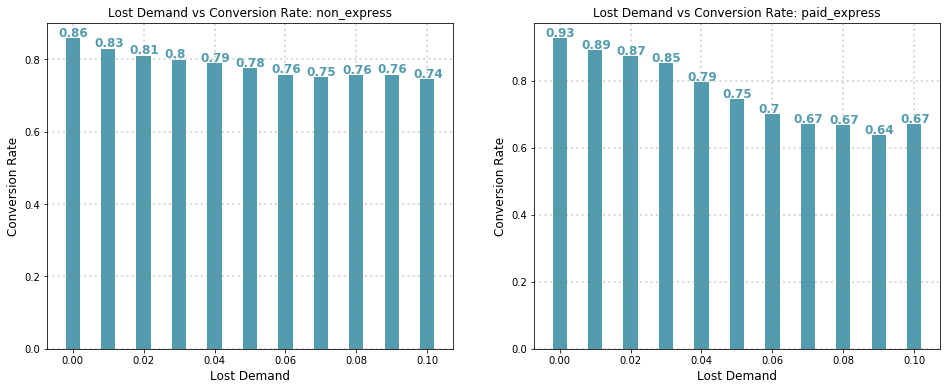

In [22]:
ind_width = 0.004

x = df_lost_conversion[(df_lost_conversion['user_type'] == 2)\
                        & (df_lost_conversion['lost_range'] <= 0.15)]['lost_range']

y1 = df_lost_conversion[(df_lost_conversion['user_type'] == 2)\
                        & (df_lost_conversion['lost_range'] <= 0.15)]['conversion_rate']
y2 = df_lost_conversion[(df_lost_conversion['user_type'] == 5)\
                        & (df_lost_conversion['lost_range'] <= 0.15)]['conversion_rate']

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Conversion Rate',fontsize=12)
ax1.set_title('Lost Demand vs Conversion Rate: non_express')
for i, v in enumerate(y1):
    ax1.text(i * 0.01 - 0.004, v + 0.005, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('Lost Demand',fontsize=12)
ax2.set_ylabel('Conversion Rate',fontsize=12)
ax2.set_title('Lost Demand vs Conversion Rate: paid_express')
for i, v in enumerate(y2):
    ax2.text(i * 0.01 - 0.004, v + 0.005, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost Demand Vs Conversion Final 7.0.png')
plt.show()

#### Interaction Features

In [23]:
import math
user_df['lost_d_visit'] = user_df['lost_estimate'] / user_df['visit']
user_df['lost_true_d_visit'] = user_df['lost_true'] / user_df['visit']

### Examine LD Model: How does the lost_estimate distribution looks like?

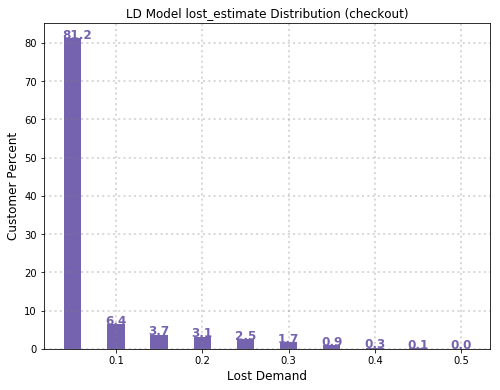

In [24]:
# About 65% of all users do not have lost_true_d_visit.

bound = 0.5
ind_width = round(bound / float(25), 3)

x = [(i + 1) * bound / 10 for i in range(10)]

tot = len(df_lds_orders)
y0, division0 = np.histogram(df_lds_orders[df_lds_orders['lost_estimate'] <= bound]\
                             ['lost_estimate'])
y = [i / float(tot) * 100 for i in y0]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x, y, align='center', color='#7663b0', width=ind_width)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('LD Model lost_estimate Distribution (checkout)')
for i, v in enumerate(y):
    ax1.text((i + 0.75) * bound / 10, v, str(round(v, 1)),\
             color='#7663b0', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost Delivery Session Calculation.png')
plt.show()

## Examine LD Model: does the model differentiate converted from converted

1032673 is Converted and 123683 is Not Converted.


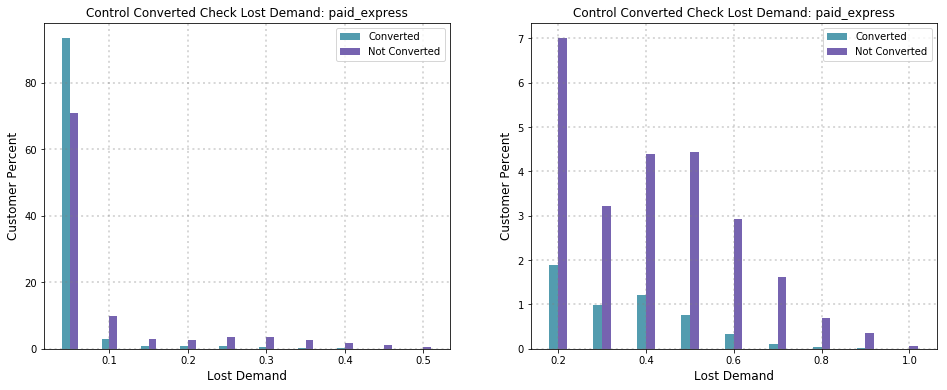

In [25]:
lost_sum = lost_calculation[['user_id', 'user_type', 'converted', 'lost_estimate']].copy()

x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
x1 = [a - 0.005 for a in x]
x2 = [a + 0.005 for a in x]

ttt_type = 5

tot_1 = len(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)]) 
y1, division1 = np.histogram(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 0.5)]['lost_estimate'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)]) 
y2, division2 = np.histogram(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 0.5)]['lost_estimate'])
y2 = [i / float(tot_2) * 100 for i in y2]
            
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x1, y1, align='center', color='#539caf',label='Converted', width=0.01)
ax1.bar(x2, y2, align='center', color='#7663b0', label='Not Converted', width=0.01)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Control Converted Check Lost Demand: '\
              + user_type_map_reverse[ttt_type])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)


x0 = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
x3 = [a - 0.01 for a in x0]
x4 = [a + 0.01 for a in x0]

y3, division3 = np.histogram(lost_sum[(lost_sum['converted'] == True)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 1.0)]['lost_estimate'])
y3 = [i / float(tot_1) * 100 for i in y3]

y4, division4 = np.histogram(lost_sum[(lost_sum['converted'] == False)\
                     & (lost_sum['user_type'] == ttt_type)\
                     & (lost_sum['lost_estimate'] <= 1.0)]['lost_estimate'])
y4 = [i / float(tot_2) * 100 for i in y4]
            
ax2 = fig.add_subplot(122)
ax2.bar(x3[1:], y3[1:], align='center', color='#539caf',label='Converted', width=0.02)
ax2.bar(x4[1:], y4[1:], align='center', color='#7663b0', label='Not Converted', width=0.02)
ax2.set_xlabel('Lost Demand',fontsize=12)
ax2.set_ylabel('Customer Percent',fontsize=12)
ax2.set_title('Control Converted Check Lost Demand: '\
              + user_type_map_reverse[ttt_type])
ax2.legend(loc = 'upper right',fontsize=10)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost For Converted Or Not '\
            + user_type_map_reverse[ttt_type]\
            + '.png')
print('%6d is Converted and %6d is Not Converted.'%(tot_1, tot_2))
plt.show()

## Get DataFrame For The Second 28 Days.

In [26]:
df_labels = pd.concat([df_lds_orders_201810, df_lds_orders_201811])
df_labels = user_ids.merge(df_labels, on=['user_id'], how='left')
df_labels = df_labels[(df_labels['date'] >= df_labels['last_date'])\
                      & (df_labels['date'] < df_labels['label_date'])]

## Feature Engineers For Labels

In [27]:
# Get orders for this period.
label_orders = get_orders(df_labels[['user_id', 'date', 'converted']])

# Get visits for the period, visit per day is 0 or 1.
label_visits = get_visits(df_labels[['user_id', 'date']])

label_df = user_ids.merge(label_visits, on=['user_id'], how='left')
label_df = label_df.merge(label_orders, on=['user_id'], how='left')

label_df = label_df.rename(columns={'visit':'label_visit', 'order':'label_order'})\
    .drop(columns=['first_date', 'last_date', 'label_date'], axis=1)
label_df.fillna(value={'label_visit': 0, 'label_order':0}, inplace=True)

In [28]:
label_df.head(3)

,user_id,label_visit,label_order
0,11,0.0,0.0
1,22,5.0,0.0
2,52,2.0,0.0


### Join Features and Labels Together

In [29]:
df_explore = user_df.merge(label_df, on=['user_id'], how='left')
df_explore['conversion_rate'] = df_explore['order'] / df_explore['visit']

## User Statistics

In [30]:
user_type_count

,user_type,count_first,count_last
0,non_express,431892,439728
1,free_express,159587,143596
2,discount_express,1010,1004
3,paid_express,308738,316899


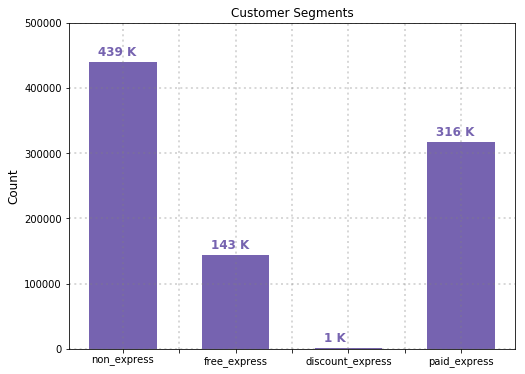

In [31]:
x = [1,2,3,4]
x1 = [a - 0.2 for a in x]
x2 = [a + 0.2 for a in x]
y1 = user_type_count.count_first.tolist()
y2 = user_type_count.count_last.tolist()
ind_width = 0.6

fig, ax = plt.subplots(figsize=(8,6))
#ax.bar(x1, y1, align='center', color='#539caf',label='Beginning', width=ind_width)
ax.bar(x, y2, align='center', color='#7663b0', width=ind_width)
ax.set_ylabel('Count',fontsize=12)
ax.set_title('Customer Segments')
ax.set_ylim([0, 500000])
for i, v in enumerate(y2):
    ax.text(i + 0.78, v + 10000, str(int(v/1000)) + ' K', color='#7663b0', fontweight='bold', fontsize=12)
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.set_xticklabels(('', 'non_express', '', 'free_express', '',\
                    'discount_express', '', 'paid_express'))
plt.savefig(time_period + ' User Type Changes.png')
plt.show()

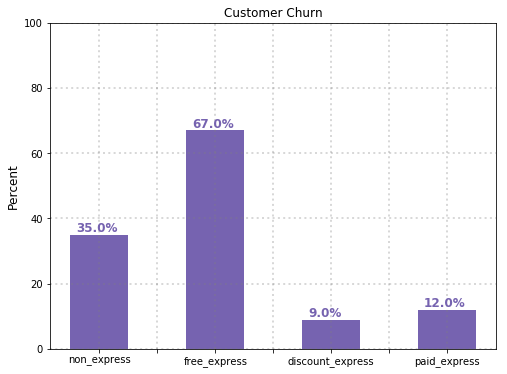

In [32]:
x = [1,2,3,4]
y1 = user_type_count.count_last.tolist()
t = label_df.merge(user_type_last, on=['user_id'], how='left')
y2 = t[t['label_visit'] != 0][['user_type',\
        'label_visit']].groupby('user_type').count().label_visit.tolist()
y3 = [round(1 - i / float(j), 2)*100 for i, j in zip(y2, y1)]

fig, ax = plt.subplots(figsize=(8,6))
ax.bar(x, y3, align='center',\
       color='#7663b0', width=0.5)
#ax.set_xlabel('Customer Type',fontsize=12)
ax.set_ylabel('Percent',fontsize=12)
for i, v in enumerate(y3):
    ax.text(i + 0.8, v + 1, str(v) + '%', color='#7663b0', fontweight='bold', fontsize=12)
ax.set_ylim([0,100])
ax.set_title('Customer Churn')
ax.set_xticklabels(('', 'non_express', '','free_express', '', 'discount_express','', 'paid_express'))
plt.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
plt.savefig(time_period + ' User Churned.png')
plt.show()

## About User Statistics Of Orders, Visits, Warehouse and Lost Deliveries

We don't need to consider new users in our model since new users almost all have one visit and 0 orders.

In [33]:
# What threshold to use to get good histogram.

k = 5
label = 'lost_estimate'
t_tot = float(len(df_explore[df_explore['user_type'] == k]))
t2 = df_explore[(df_explore['user_type'] == k)\
                & (df_explore[label] >= 0)\
               & (df_explore[label] < 0.1)][label]
count2, division2 = np.histogram(t2)
count2 = [round(i / t_tot, 3) * 100 for i in count2]
sum(count2)

80.70000000000002

In [34]:
user_stats = {}

for k in [2, 3, 4, 5]:
    
    t_tot = float(len(user_df[user_df['user_type'] == k]))
    
    t1 = user_df[(user_df['user_type'] == k) & (user_df['lost_true_d_visit'] <= 0.2)]['lost_true_d_visit']
    count1, division1 = np.histogram(t1)
    count1 = [round(i / t_tot, 3) * 100 for i in count1]

    t2 = user_df[(user_df['user_type'] == k) & (user_df['order'] <= 10)]['order']
    count2, division2 = np.histogram(t2)
    count2 = [round(i / t_tot, 3) * 100 for i in count2]

    t3 = user_df[(user_df['user_type'] == k) & (user_df['visit'] <= 11)]['visit']
    count3, division3 = np.histogram(t3)
    count3 = [round(i / t_tot, 3) * 100 for i in count3]

    t4 = user_df[(user_df['user_type'] == k) & (user_df['warehouse_daily_avg'] <= 6)]['warehouse_daily_avg']
    count4, division4 = np.histogram(t4)
    count4 = [round(i / t_tot, 3) * 100 for i in count4]
    
    t5 = df_explore[(df_explore['user_type'] == k) & (df_explore['label_visit'] <= 10)]['label_visit']
    count5, division5 = np.histogram(t5)
    count5 = [round(i / t_tot, 3) * 100 for i in count5]
    
    t6 = df_explore[(df_explore['user_type'] == k) & (df_explore['label_order'] <= 10)]['label_order']
    count6, division6 = np.histogram(t6)
    count6 = [round(i / t_tot, 3) * 100 for i in count6]

    user_stats[user_type_map_reverse[k]] =pd.DataFrame({'Order': division2[:-1],
                                                        'OPct': count2,
                                                        'Visit': division3[:-1],
                                                        'VPct': count3,
                                                        'Lost': division1[:-1],
                                                        'LPct': count1,
                                                        'Warehouse': division4[:-1],
                                                        'WPct': count4,
                                                         'LVisit': division5[:-1],
                                                        'LVPct': count5,
                                                         'LOrder': division6[:-1],
                                                        'LOPct': count6,})
    user_stats[k] = user_stats[user_type_map_reverse[k]][['Order',\
                                           'OPct', 'Visit', 'VPct',\
                                           'Lost', 'LPct', \
                                            'LVisit', 'LVPct',\
                                            'LOrder', 'LOPct']]
    
    print('\nFor %s:'%(user_type_map_reverse[k]))
    print(user_stats[k])


For non_express:
   Order  OPct  Visit  VPct      Lost  LPct  LVisit  LVPct  LOrder  LOPct
0    0.0  15.9    1.0  49.9  0.000000  14.7     0.0   34.7     0.0   51.7
1    1.0  44.8    2.0  24.7  0.019998   3.5     1.0   18.9     1.0   22.9
2    2.0  20.8    3.0  12.5  0.039996   2.4     2.0   13.8     2.0   12.3
3    3.0   9.8    4.0   6.5  0.059993   1.9     3.0    9.5     3.0    6.5
4    4.0   4.7    5.0   3.1  0.079991   1.5     4.0    6.8     4.0    3.5
5    5.0   2.1    6.0   1.5  0.099989   1.2     5.0    4.7     5.0    1.5
6    6.0   0.9    7.0   0.8  0.119987   1.1     6.0    3.2     6.0    0.7
7    7.0   0.4    8.0   0.4  0.139985   1.0     7.0    2.3     7.0    0.4
8    8.0   0.2    9.0   0.2  0.159982   0.9     8.0    1.6     8.0    0.2
9    9.0   0.2   10.0   0.2  0.179980   0.8     9.0    1.9     9.0    0.2

For free_express:
   Order  OPct  Visit  VPct      Lost  LPct  LVisit  LVPct  LOrder  LOPct
0    0.0  36.1    1.0  66.6  0.000000  25.3     0.0   66.5     0.0   80.2
1

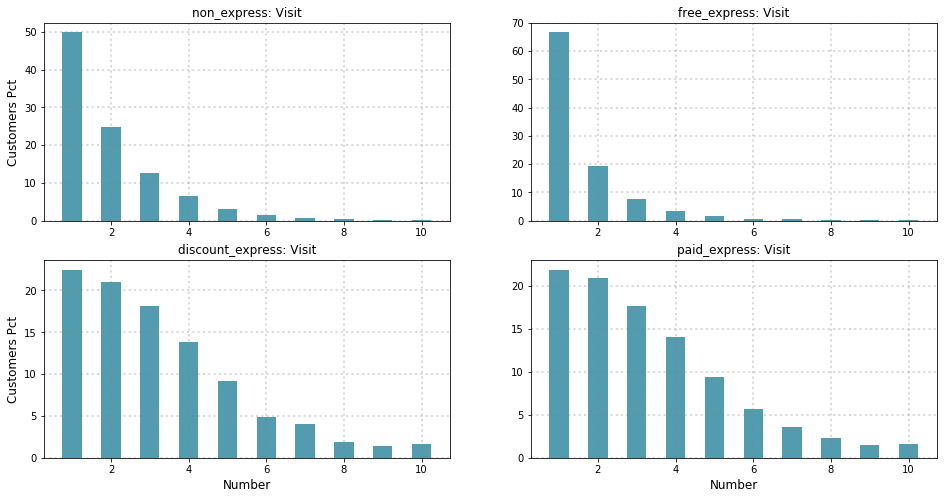

In [35]:
if True: 
    png_name = 'Customer Order Number'
    label = 'Visit'
    label_pct = 'VPct'

    fig = plt.figure(figsize=(16, 8))

    ax2 = fig.add_subplot(221)
    ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.5)
    ax2.set_title('non_express: ' + label)
    ax2.set_ylabel('Customers Pct',fontsize=12)
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    ax3 = fig.add_subplot(222)
    ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.5)
    ax3.set_title('free_express: ' + label)
    ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    ax4 = fig.add_subplot(223)
    ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.5)
    ax4.set_xlabel('Number',fontsize=12)
    ax4.set_ylabel('Customers Pct',fontsize=12)
    ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    ax4.set_title('discount_express: ' + label)

    ax5 = fig.add_subplot(224)
    ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.5)
    ax5.set_xlabel('Number',fontsize=12)
    ax5.set_title('paid_express: ' + label)
    ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    plt.savefig(time_period + ' ' + png_name + ' Distribution.png')
    plt.show()

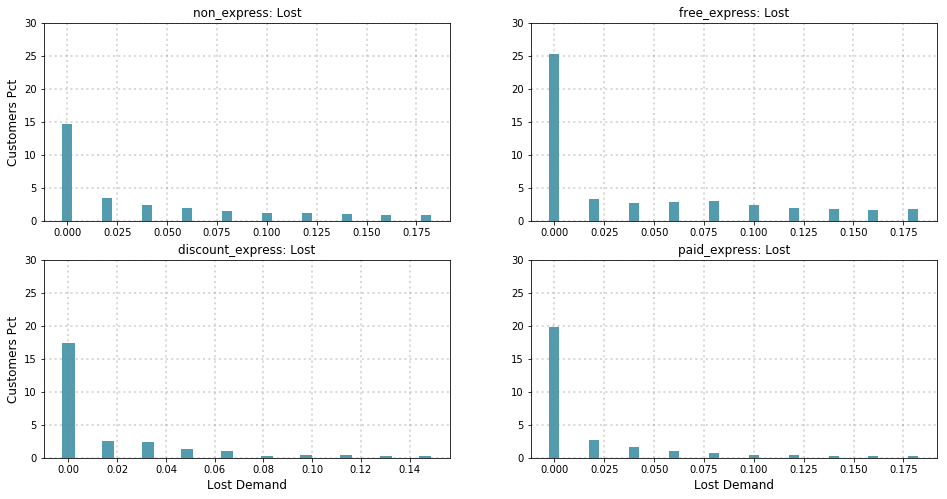

In [36]:
if True:
    # For lost_true_d_visit
    label = 'Lost'
    label_pct = 'LPct'
    png_name = 'Customer Lost Delivery Number'

    fig = plt.figure(figsize=(16, 8))

    ax2 = fig.add_subplot(221)
    ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.005)
    ax2.set_title('non_express: ' + label)
    ax2.set_ylabel('Customers Pct',fontsize=12)
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    ax2.set_ylim([0, 30])

    ax3 = fig.add_subplot(222)
    ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.005)
    ax3.set_title('free_express: ' + label)
    ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    ax3.set_ylim([0, 30])

    ax4 = fig.add_subplot(223)
    ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.005)
    ax4.set_xlabel('Lost Demand',fontsize=12)
    ax4.set_ylabel('Customers Pct',fontsize=12)
    ax4.set_title('discount_express: ' + label)
    ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    ax4.set_ylim([0, 30])

    ax5 = fig.add_subplot(224)
    ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.005)
    ax5.set_xlabel('Lost Demand',fontsize=12)
    ax5.set_title('paid_express: ' + label)
    ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
    ax5.set_ylim([0, 30])

    plt.savefig(time_period + ' ' + png_name + ' Distribution.png')
    plt.show()

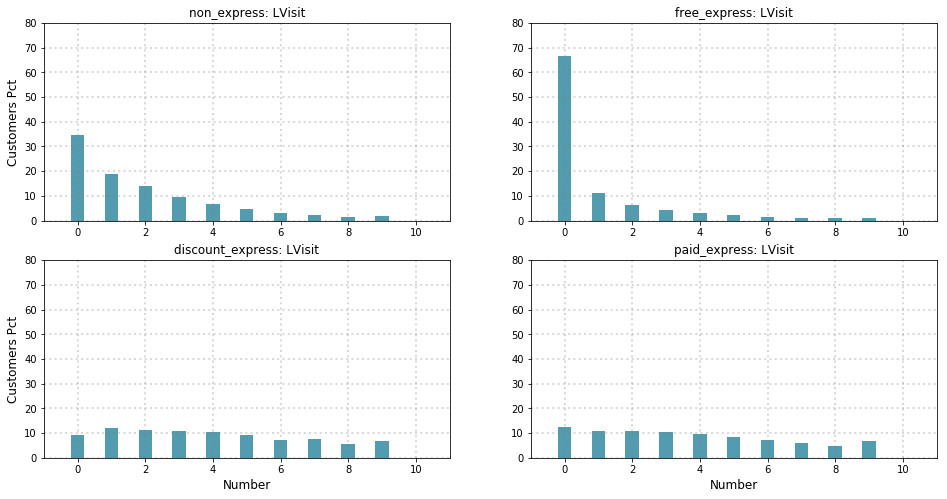

In [37]:
if True:
    # For Label Visit
    label = 'LVisit'
    label_pct = 'LVPct'
    png_name = 'Customer Visit'

    fig = plt.figure(figsize=(16, 8))

    ax2 = fig.add_subplot(221)
    ax2.bar(user_stats[2][label], user_stats[2][label_pct], align='center', color='#539caf', width=0.4)
    ax2.set_title('non_express: ' + label)
    ax2.set_ylabel('Customers Pct',fontsize=12)
    ax2.set_xlim([-1,11])
    ax2.set_ylim([0, 80])
    ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    ax3 = fig.add_subplot(222)
    ax3.bar(user_stats[3][label], user_stats[3][label_pct], align='center', color='#539caf', width=0.4)
    ax3.set_title('free_express: ' + label)
    ax3.set_xlim([-1,11])
    ax3.set_ylim([0, 80])
    ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    ax4 = fig.add_subplot(223)
    ax4.bar(user_stats[4][label], user_stats[4][label_pct], align='center', color='#539caf', width=0.4)
    ax4.set_xlabel('Number',fontsize=12)
    ax4.set_ylabel('Customers Pct',fontsize=12)
    ax4.set_title('discount_express: ' + label)
    ax4.set_xlim([-1,11])
    ax4.set_ylim([0, 80])
    ax4.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    ax5 = fig.add_subplot(224)
    ax5.bar(user_stats[5][label], user_stats[5][label_pct], align='center', color='#539caf', width=0.4)
    ax5.set_xlabel('Number',fontsize=12)
    ax5.set_title('paid_express: ' + label)
    ax5.set_xlim([-1,11])
    ax5.set_ylim([0, 80])
    ax5.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

    plt.savefig(time_period + ' ' + png_name + ' Distribution.png')
    plt.show()

## Explore implicit churn rate

[14346  2774  2498  3067  3712  4079  2649   764   286   105]
[6750 1972 1996 1244  483  347  171   56   16    9]
[2510  901  587  263  173   81   30   24    3    4]


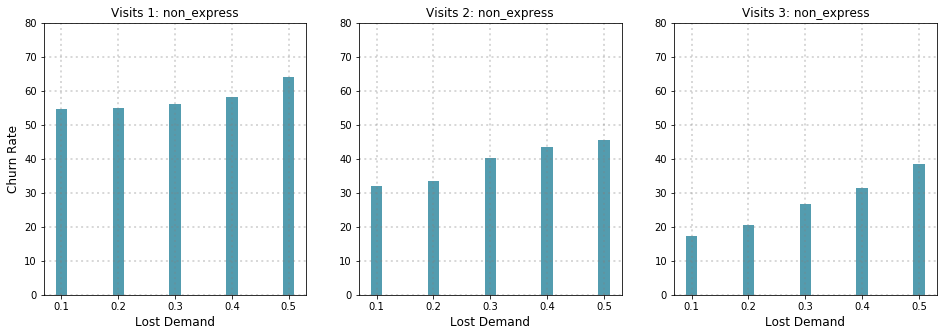

In [38]:
ind_width = 0.01
t_type = 2
variable = 'lost_true_d_visit'
x_label = 'Lost Demand'

fig = plt.figure(figsize=(16, 5))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

y01, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 1)
           & (df_explore['visit'] < 2)][variable])

y1, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 1)
           & (df_explore['visit'] < 2)][variable])
print(y1)
y1 = [i / float(j) * 100 for i, j in zip(y1, y01)]

ax1 = fig.add_subplot(131)
ax1.bar(x[:5], y1[:5], align='center', color='#539caf', width=ind_width)
ax1.set_xlabel(x_label,fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
ax1.set_ylim([0, 80])
ax1.set_title('Visits 1: ' + str(user_type_map_reverse[t_type]))
ax1.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

y02, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 2)
           & (df_explore['visit'] < 3)][variable])

y2, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 2)
           & (df_explore['visit'] < 3)][variable])
print(y2)
y2 = [i / float(j) * 100 for i, j in zip(y2, y02)]

ax2 = fig.add_subplot(132)
ax2.bar(x[:5], y2[:5], align='center', color='#539caf', width=ind_width)
ax2.set_xlabel(x_label,fontsize=12)
ax2.set_ylim([0, 80])
ax2.set_title('Visits 2: ' + str(user_type_map_reverse[t_type]))
ax2.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

y03, division0 = np.histogram(df_explore[(df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 3)
           & (df_explore['visit'] < 4)][variable])

y3, division1 = np.histogram(df_explore[(df_explore['label_visit'] == 0)\
           & (df_explore['user_type'] == t_type)\
           & (df_explore[variable] <= 0.5)\
           & (df_explore['visit'] >= 3)
           & (df_explore['visit'] < 4)][variable])
print(y3)
y3 = [i / float(j) * 100 for i, j in zip(y3, y03)]

ax3 = fig.add_subplot(133)
ax3.bar(x[:5], y3[:5], align='center', color='#539caf', width=ind_width)
ax3.set_xlabel(x_label,fontsize=12)
ax3.set_ylim([0, 80])
ax3.set_title('Visits 3: ' + str(user_type_map_reverse[t_type]))
ax3.set_xticklabels(('', '0.1', '0.2', '0.3', '0.4', '0.5'))
ax3.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Customer Implicit Churn Rate '\
            + str(user_type_map_reverse[t_type]) + '.png')
plt.show()

### Explore for 1 visit users, how do their label_visit distribution looks like?

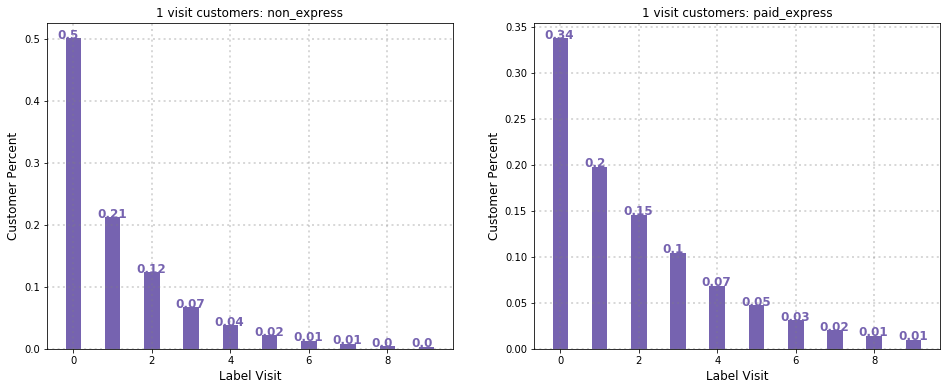

In [39]:
t_user_type = 2
x = [0,1,2,3,4,5,6,7,8,9]

tot = len(df_explore[(df_explore['user_type'] == t_user_type)\
           & (df_explore['visit'] == 1)])
count, bins = np.histogram(df_explore[(df_explore['user_type'] == t_user_type)\
           & (df_explore['visit'] == 1)\
           & (df_explore['label_visit'] < 10)]['label_visit'])
y = [i / float(tot) for i in count]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x, y, align='center', color='#7663b0', width=0.4)
ax1.set_xlabel('Label Visit',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('1 visit customers: ' + user_type_map_reverse[t_user_type])
for i, v in enumerate(y):
    ax1.text(i - 0.4, v, str(round(v,2)), color='#7663b0', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)


t_user_type2 = 5
tot2 = len(df_explore[(df_explore['user_type'] == t_user_type2)\
           & (df_explore['visit'] == 1)])
count2, bins = np.histogram(df_explore[(df_explore['user_type'] == t_user_type2)\
           & (df_explore['visit'] == 1)\
           & (df_explore['label_visit'] < 10)]['label_visit'])
y2 = [i / float(tot2) for i in count2]

ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#7663b0', width=0.4)
ax2.set_xlabel('Label Visit',fontsize=12)
ax2.set_ylabel('Customer Percent',fontsize=12)
for i, v in enumerate(y2):
    ax2.text(i - 0.4, v, str(round(v,2)), color='#7663b0', fontweight='bold', fontsize=12)
ax2.set_title('1 visit customers: ' + user_type_map_reverse[t_user_type2])
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.show()

### Explore zone region difference

In [40]:
df_explore.head(3)

,user_id,lost_estimate,order,visit,warehouse_daily_avg,visit_interval,num_warehouse,user_type,visit_lost,lost_true,lost_d_visit,lost_true_d_visit,label_visit,label_order,conversion_rate
0,11,0.005245,1.0,1,1.0,28.0,1,2,NaN,NaN,0.005245,NaN,0.0,0.0,1.0
1,22,0.000000,1.0,1,1.0,4.0,1,3,NaN,NaN,0.000000,NaN,5.0,0.0,1.0
2,59,0.000878,1.0,1,1.0,28.0,1,5,NaN,NaN,0.000878,NaN,0.0,0.0,1.0


In [41]:
data_sf = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'] == 1].user_id.tolist())]\
                     .copy()
data_sf['label'] = data_sf['label_visit'] - data_sf['visit']
data_miami = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'] == 79].user_id.tolist())]\
                     .copy()
data_miami['label'] = data_miami['label_visit'] - data_miami['visit']
data_manhattan = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'].isin([18, 27])].user_id.tolist())]\
                     .copy()
data_manhattan['label'] = data_manhattan['label_visit'] - data_manhattan['visit']
data_la = df_explore[df_explore['user_id']\
                     .isin(user_zones[user_zones['zone_id'].isin([972, 983, 1002])].user_id.tolist())]\
                     .copy()
data_la['label'] = data_la['label_visit'] - data_la['visit']

In [42]:
print('Total %6d users in SF, and %6d users in Miami.'%(len(data_sf), len(data_miami)))
print('Total %6d users in Manhattan, and %6d users in LA.'%(len(data_manhattan), len(data_la)))
print('Total %6d non_express in SF, and %6d non_express in Miami.'\
      %(len(data_sf[data_sf['user_type'] == 2]), len(data_miami[data_miami['user_type'] == 2])))
print('Total %6d non_express in SF, and %6d non_express in Miami.'\
      %(len(data_sf[data_sf['user_type'] == 5]), len(data_miami[data_miami['user_type'] == 5])))

Total  21302 users in SF, and  13335 users in Miami.
Total  26730 users in Manhattan, and  42531 users in LA.
Total   9553 non_express in SF, and   6452 non_express in Miami.
Total   9722 non_express in SF, and   5634 non_express in Miami.


[465 149 138  86  43  26   8   6   0   1]
[121  14  12  18  12   8   6   2   2   4]


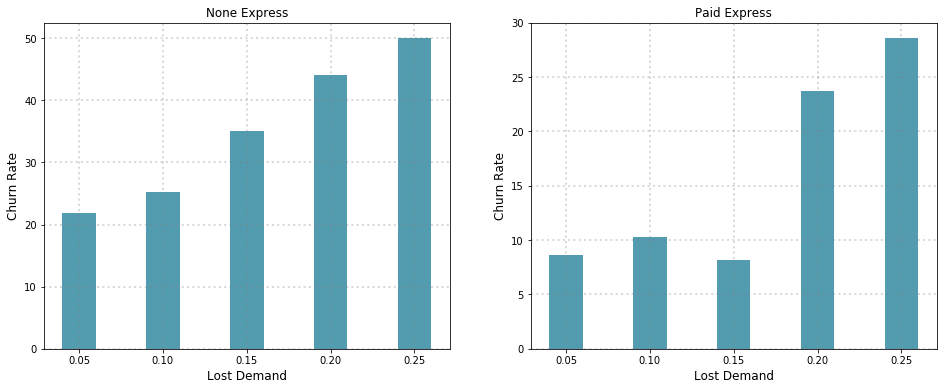

In [43]:
t_df = data_la
ind_width = 0.02
lower = 2
upper = 5
variable = 'lost_true_d_visit'
x_label = 'Lost Demand'

fig = plt.figure(figsize=(16, 6))
x = [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

t_type1 = 2
y0, division0 = np.histogram(t_df[(t_df['user_type'] == t_type1)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])

y1, division1 = np.histogram(t_df[(t_df['label_visit'] == 0)\
           & (t_df['user_type'] == t_type1)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])
print(y1)
y1 = [i / float(j) * 100 for i, j in zip(y1, y0)]

ax1 = fig.add_subplot(121)
ax1.bar(x[:5], y1[:5], align='center', color='#539caf', width=ind_width)
ax1.set_xlabel(x_label, fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
ax1.set_title('None Express')
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

t_type2 = 5
y, division = np.histogram(t_df[(t_df['user_type'] == t_type2)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])

y3, division3 = np.histogram(t_df[(t_df['label_visit'] == 0)\
           & (t_df['user_type'] == t_type2)\
           & (t_df[variable] <= 0.5)\
           & (t_df['visit'] >= lower)
           & (t_df['visit'] < upper)][variable])
print(y3)
y3 = [i / float(j) * 100 for i, j in zip(y3, y)]

ax2 = fig.add_subplot(122)
ax2.bar(x[:5], y3[:5], align='center', color='#539caf', width=ind_width)
ax2.set_xlabel(x_label,fontsize=12)
ax2.set_ylabel('Churn Rate',fontsize=12)
ax2.set_title('Paid Express')
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Zone Lost Deliveries vs Churn  '\
            + str(lower) + '_' + str(upper) + '.png')
plt.show()

#### Check Zone Level whether +Visit users have less lost demand 

[148  92  74  58  34  35  30  20  19  13]
[163 110  98  74  39  40  38  28  24  13]
   598 is +1 Delta Visit and    673 is -1 Delta Visit.


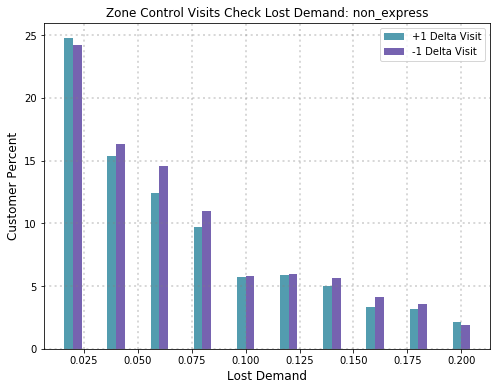

In [44]:
ind_width = 0.004

x = [0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14, 0.16, 0.18, 0.2]
x1 = [a - 0.002 for a in x]
x2 = [a + 0.002 for a in x]

t_type = 2
t_df = data_sf[data_sf['user_type'] == t_type].copy()
lower_bound = 1
upper_bound = 3

tot_1 = len(t_df[(t_df['label'] >= lower_bound)\
                 & (t_df['label'] < upper_bound) & (t_df['lost_true'].notnull())])
y1, division1 = np.histogram(t_df[(t_df['label'] >= lower_bound)\
                                  & (t_df['label'] < upper_bound)\
                                  & (t_df['lost_true_d_visit'] <= 0.2)]['lost_true_d_visit'])
print(y1)
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(t_df[(t_df['label'] >= -1 * upper_bound)\
                 & (t_df['label'] < -1 * lower_bound) & (t_df['lost_true'].notnull())])
y2, division2 = np.histogram(t_df[(t_df['label'] >= -1 * upper_bound)\
                                  & (t_df['label'] < -1 * lower_bound)\
                                  & (t_df['lost_true_d_visit'] <= 0.2)]['lost_true_d_visit'])
print(y2)
y2 = [i / float(tot_2) * 100 for i in y2]

fig = plt.figure(figsize=(8, 6))
ax1 = fig.add_subplot(111)
ax1.bar(x1, y1, align='center', color='#539caf',label='+'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.bar(x2, y2, align='center', color='#7663b0', label='-'+ str(lower_bound) + ' Delta Visit', width=ind_width)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Zone Control Visits Check Lost Demand: '\
              + user_type_map_reverse[t_type])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost For Different Delta Visit '\
            + user_type_map_reverse[t_type]\
            + '_' + str(lower_bound) + '_' \
            + str(upper_bound) + '_SF.png')
print('%6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(tot_1, tot_2))
plt.show()

## Feature Engineering For User Infos

In [45]:
def get_email_type(x):
    
    m = re.search(r'(\S+)@(\S+)', x)
    
    return m.group(2)

if False:
    user_infos['email_type'] = user_infos['email'].map(lambda x: get_email_type(x))
    
user_infos['has_phone'] = user_infos['phone'].notnull().map(lambda x: 1 if x else 0)

user_infos.rename(columns={'id':'user_id'}, inplace=True)
user_infos = user_infos.merge(user_ids, on=['user_id'])
user_infos['life_days'] = (user_infos['last_date'] - user_infos['created_at']).map(lambda x: x.days) 

user_info_df = user_infos[['user_id', 'has_phone', 'gender',\
                           'receive_emails', 'life_days']].copy()

In [46]:
user_infos.head(3)

,user_id,name,email,phone,became_express_member_on,sign_in_count,active,gender,receive_emails,household_income,...,converted_from_id,converted_to_id,first_name,last_name,created_at,has_phone,first_date,last_date,label_date,life_days
0,35322,Meredith Zappert,meredith.story@gmail.com,4109910716,NaT,74,True,female,True,None,...,NaN,None,Meredith,Zappert,2013-07-03 19:25:09.000000,1,2018-09-04,2018-10-02,2018-10-30,1916
1,38936,Yi,zhengyi8341@gmail.com,6503538692,NaT,10,True,male,False,None,...,NaN,None,Yi,None,2013-07-24 03:12:22.000000,1,2018-09-16,2018-10-14,2018-11-11,1907
2,71321,None,jentosic@sbcglobal.net,7734809198,NaT,5,True,None,True,None,...,NaN,None,Jen,Kudesh,2013-12-06 01:15:12.625791,1,2018-09-04,2018-10-02,2018-10-30,1760


In [47]:
user_info_df.isnull().sum()

user_id                 0
has_phone               0
gender            1885066
receive_emails          0
life_days               0
dtype: int64

## Model Train

Features considered: 'lost_estimate', 'visit', 'has_phone', 'life_days', 'gender_male', 'gender_female', 'warehouse_daily_avg', 'receive_emails', 'life_days'

In [48]:
df = user_df.merge(user_info_df, on=['user_id'])
df = df.merge(label_df, on=['user_id'])
df['gender'] = df['gender'].map(lambda x: 'male' if x == 'male (hidden)'\
                                else 'female' if x == 'female (hidden)' else x)
df = df.join(pd.get_dummies(df.gender, prefix='gender'))
df['receive_emails'] = df['receive_emails'].map(lambda x: 1 if x else 0)
df.rename(columns={"gender_female (hidden)":"gender_female_hidden",\
                   "gender_male (hidden)":"gender_male_hidden"}, inplace=True)

In [49]:
df.columns

Index([            u'user_id',       u'lost_estimate',               u'order',
                     u'visit', u'warehouse_daily_avg',      u'visit_interval',
             u'num_warehouse',           u'user_type',          u'visit_lost',
                 u'lost_true',        u'lost_d_visit',   u'lost_true_d_visit',
                 u'has_phone',              u'gender',      u'receive_emails',
                 u'life_days',         u'label_visit',         u'label_order',
             u'gender_female',         u'gender_male'],
      dtype='object')

## Does Lost Demand Impact Churn

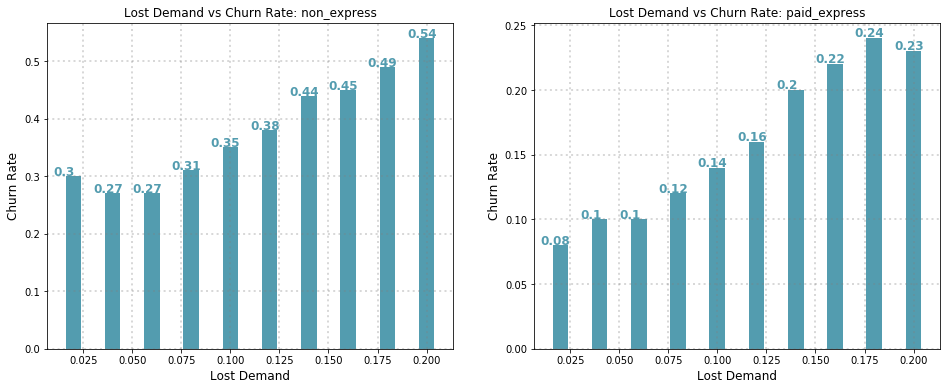

In [50]:
ind_width = 0.008

x = [(i + 1) * 0.02 for i in range(10)]

y01, division01 = np.histogram(df[(df['user_type'] == 2)\
                                & (df['lost_true_d_visit'] <= 0.2)]['lost_true_d_visit'])
y1, division1 = np.histogram(df[(df['user_type'] == 2)\
                                & (df['lost_true_d_visit'] <= 0.2)\
                                & (df['label_visit'] == 0)]['lost_true_d_visit'])
y1 = [round(i/float(j), 2) for i, j in zip(y1, y01)]

y02, division02 = np.histogram(df[(df['user_type'] == 5)\
                                & (df['lost_true_d_visit'] <= 0.2)]['lost_true_d_visit'])
y2, division2 = np.histogram(df[(df['user_type'] == 5)\
                                & (df['lost_true_d_visit'] <= 0.2)\
                                & (df['label_visit'] == 0)]['lost_true_d_visit'])
y2 = [round(i/float(j), 2) for i, j in zip(y2, y02)]

fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121)
ax1.bar(x, y1, align='center', color='#539caf', width=ind_width)
ax1.set_xlabel('Lost Demand',fontsize=12)
ax1.set_ylabel('Churn Rate',fontsize=12)
ax1.set_title('Lost Demand vs Churn Rate: non_express')
for i, v in enumerate(y1):
    ax1.text(i * 0.02 + 0.01, v + 0.001, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

ax2 = fig.add_subplot(122)
ax2.bar(x, y2, align='center', color='#539caf', width=ind_width)
ax2.set_xlabel('Lost Demand',fontsize=12)
ax2.set_ylabel('Churn Rate',fontsize=12)
ax2.set_title('Lost Demand vs Churn Rate: paid_express')
for i, v in enumerate(y2):
    ax2.text(i * 0.02 + 0.01, v + 0.001, str(round(v, 2)), color='#539caf', fontweight='bold', fontsize=12)
ax2.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost Demand Vs Churn Final.png')
plt.show()

## Get DataFrame Ready For Modeling

In [51]:
# Get train, test and predict DataFrame
delta_list = [i * 0.008 for i in range(5)]
user_type_model = 5 # [1, 2, 3, 5]. Not Working for 4, too few records.
    
data = df[(df['user_type'] == user_type_model)\
      & (df['lost_true_d_visit'].notnull())]\
            .copy().reset_index()\
            .drop(['index', 'user_id', 'gender'], axis=1)
data['label'] = data['label_visit'] - data['visit']
data_Y = data['label'].copy()

# Get useful mean() and std().
visit_mean = data['visit'].mean()
visit_std = data['visit'].std()
lost_true_d_visit_mean = data['lost_true_d_visit'].mean()
lost_true_d_visit_std = data['lost_true_d_visit'].std()

# Normalize Features
data = (data - data.mean()) / data.std()

data_train, data_test, train_y, test_y = train_test_split(data, data_Y, test_size=.1)

### Exam any relationship

#### Check whether the lost_true_d_visit differ between +1 visit and -1 visit customers

For visit 1 - 4,   2247 is +1 Delta Visit and   1489 is -1 Delta Visit.


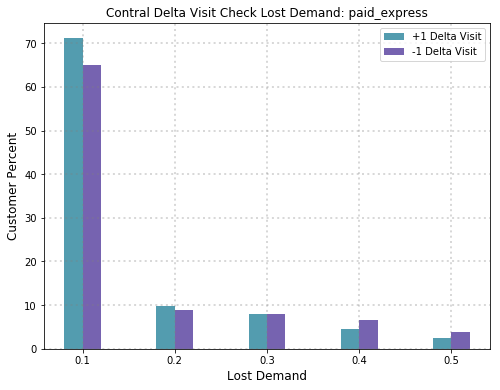

In [52]:
ind_width = 0.02

fig = plt.figure(figsize=(8, 6))
x = [(i + 1) * 0.1 for i in range(10)]
x1 = [a - 0.01 for a in x]
x2 = [a + 0.01 for a in x]

lower1 = 1
upper1 = 4

tot_1 = len(data[(data['visit'] >= lower1)\
                 & (data['visit'] < upper1)\
                 & (data['lost_true_d_visit'].notnull())\
                 & (data['label'] >= 1)\
                 & (data['label'] < 3)])
y1, division1 = np.histogram(data[(data['visit'] >= lower1)\
                                  & (data['visit'] < upper1)\
                                  & (data['lost_true_d_visit'] <= 1.0)\
                                  & (data['label'] >= 1)\
                                  & (data['label'] < 3)]['lost_true_d_visit'])
y1 = [i / float(tot_1) * 100 for i in y1]

tot_2 = len(data[(data['visit'] >= lower1)\
                 & (data['visit'] < upper1)\
                 & (data['lost_true_d_visit'].notnull())\
                 & (data['label'] >= -3)\
                 & (data['label'] < -1)])
y2, division2 = np.histogram(data[(data['visit'] >= lower1)\
                                  & (data['visit'] < upper1)\
                                  & (data['lost_true_d_visit'] <= 1.0)\
                                  & (data['label'] >= -3)\
                                  & (data['label'] < -1)]['lost_true_d_visit'])
y2 = [i / float(tot_2) * 100 for i in y2]

ax1 = fig.add_subplot(111)
ax1.bar(x1[:5], y1[:5], align='center', color='#539caf',label='+1 Delta Visit', width=ind_width)
ax1.bar(x2[:5], y2[:5], align='center', color='#7663b0', label='-1 Delta Visit', width=ind_width)
#ax1.plot(x[:5], [i / float(j) for i, j in zip(y1[:5], y2[:5])], 'go-', linewidth=2, color='#539caf')
ax1.set_xlabel('Lost Demand', fontsize=12)
ax1.set_ylabel('Customer Percent',fontsize=12)
ax1.set_title('Contral Delta Visit Check Lost Demand: '\
              + user_type_map_reverse[user_type_model])
ax1.legend(loc = 'upper right',fontsize=10)
ax1.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)

plt.savefig(time_period + ' Lost vs Visit vs Delta Visit '\
            + user_type_map_reverse[user_type_model]\
            + '_' + str(lower1) + '_' \
            + str(upper1) + '_6.0.png')
print('For visit %s - %s, %6d is +1 Delta Visit and %6d is -1 Delta Visit.'%(lower1, upper1, tot_1, tot_2))
plt.show()

## Modeling

### User Linear Regression

In [53]:
model_type = 'lasso' # 'ridge', 'lasso', 'elasticnet'
include_lost = True
key_feature = 'lost_true_d_visit'

clf_features = ['visit', 'order',\
                'visit_interval', 'num_warehouse',\
                'warehouse_daily_avg',\
                'has_phone', 'gender_male',\
                'gender_female']

if include_lost:
    clf_features = [key_feature] + clf_features
    
train_X = data_train[clf_features].copy()
test_X = data_test[clf_features].copy()

alpha_list = [0.0001, 0.0003, 0.0006, 0.001, 0.003,\
              0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1]

if model_type == "ridge":
    clf = linear_model.RidgeCV(alphas = alpha_list, cv = 10)
elif model_type == "lasso":
    clf = linear_model.LassoCV(alphas = alpha_list, max_iter = 5000, cv = 10)
elif model_type == "elasticnet":
    clf = linear_model.ElasticNetCV(l1_ratio = [.1, .5, .7, .9, .95, .99, 1],\
                                     alphas = alpha_list,\
                                     max_iter = 1000, cv = 3)

clf.fit(train_X, train_y)
predict_y = clf.predict(test_X)

compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

if False:
    fig, ax = plt.subplots(figsize=(8,6))
    ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
    ax.set_xlabel('Order',fontsize=12)
    ax.set_ylabel('Predict',fontsize=12)
    ax.set_title('%s Result'%(model_type))
    plt.savefig(time_period + ' LassoCV Result.png')
    plt.show()
    
print('Mean Squared Error %.2f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

/Users/jianhuitian/.virtualenvs/staffing/lib/python2.7/site-packages/sklearn/linear_model/base.py:424: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if precompute == 'auto':


Mean Squared Error 16.73.
Mean Absolute Error 3.09.
Actual mean 1.842, predict mean 1.882


In [54]:
print('Regularization %.2f.\n'%(clf.alpha_))
coef_dict = {}
for coef, feat in zip(clf.coef_, clf_features):
    coef_dict[feat] = round(coef, 3)

print('%s %s:\n'%(model_type, user_type_map_reverse[user_type_model]))
print(coef_dict)

Regularization 0.00.

lasso paid_express:

{'visit_interval': -0.439, 'visit': 0.362, 'warehouse_daily_avg': 0.429, 'lost_true_d_visit': -0.241, 'gender_female': 0.025, 'num_warehouse': 0.129, 'gender_male': -0.02, 'has_phone': 0.132, 'order': -0.398}


#### Estimate Lost Demand Impact

Get deltaOrder for 0.1, 0.2, 0.3, 0.4, 0.5 deltaLD.

In [55]:
dict_predict = {}
if include_lost: 
    deltaLD_d = []
    t_std = lost_true_d_visit_std
    for deltaLD in delta_list:

        # Add deltaLD   
        t = []
        t_l = [0 for i in range(len(clf_features) - 1)]
        for i in range(len(test_X)):
            t.append([deltaLD / t_std] + t_l)
        X2 = np.add(test_X, np.array(t))

        t_predict = clf.predict(X2)
        #print(X2[['lost_estimate', 'visit']].head(1))
        dict_predict[deltaLD] = t_predict
        deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                          round(np.mean(t_predict), 3)))

    print("deltaLD , order_mean, predicted_mean")
    for i in range(len(deltaLD_d)):
        print(deltaLD_d[i])
        
print(coef_dict)

# Normalized the change by visits of customers.
df_impact_norm = pd.DataFrame(dict_predict)
df_impact_norm = df_impact_norm.assign(visit=test_X['visit'].tolist())
df_impact_norm['visit'] = df_impact_norm['visit'].map(lambda x: x * visit_std + visit_mean)
df_impact_norm['deltaVisit'] = (df_impact_norm[delta_list[-1]] - df_impact_norm[0]) / df_impact_norm['visit']
print('\nMean is %.3f, normalized delta visit for delta LD is %.3f.'\
      %(np.mean(df_impact_norm[0]), np.mean(df_impact_norm['deltaVisit'])))

deltaLD , order_mean, predicted_mean
(0.0, 1.842, 1.882)
(0.008, 1.842, 1.854)
(0.016, 1.842, 1.825)
(0.024, 1.842, 1.797)
(0.032, 1.842, 1.768)
{'visit_interval': -0.439, 'visit': 0.362, 'warehouse_daily_avg': 0.429, 'lost_true_d_visit': -0.241, 'gender_female': 0.025, 'num_warehouse': 0.129, 'gender_male': -0.02, 'has_phone': 0.132, 'order': -0.398}

Mean is 1.882, normalized delta visit for delta LD is -0.040.


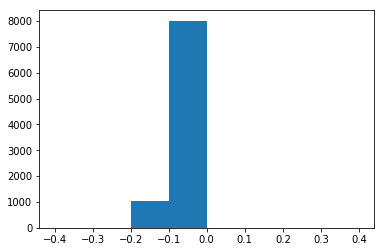

In [56]:
b = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
c, b, f = plt.hist(df_impact_norm.deltaVisit, bins=b)
plt.show()

### Use statsmodel

In [57]:
# Use the same train_X and test_X as Lasso.

X2 = sm.add_constant(train_X)
est = sm.OLS(train_y, X2)
est2 = est.fit()
# print(clf_features)
print(est2.summary())

X2 = sm.add_constant(test_X)
predict_y = est2.predict(X2)
print('\nMean Squared Error %.2f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     359.2
Date:                Wed, 06 Mar 2019   Prob (F-statistic):               0.00
Time:                        10:48:06   Log-Likelihood:            -2.2989e+05
No. Observations:               81233   AIC:                         4.598e+05
Df Residuals:                   81223   BIC:                         4.599e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.8829    

#### Estimate Lost Demand Impact

In [58]:
if include_lost: 
    deltaLD_d = []
    t_std = lost_true_d_visit_std
    for deltaLD in delta_list:

        # Add deltaLD   
        t = []
        t_l = [0 for i in range(len(clf_features) - 1)]
        for i in range(len(test_X)):
            t.append([deltaLD / t_std] + t_l)
        X2 = np.add(test_X, np.array(t))

        X2 = sm.add_constant(X2)
        t_predict = est2.predict(X2)
        #print(X2[['lost_estimate', 'visit']].head(1))
        deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                          round(np.mean(t_predict), 3)))

    print("deltaLD , order_mean, predicted_mean")
    for i in range(len(deltaLD_d)):
        print(deltaLD_d[i])
        
    print(clf_features)

deltaLD , order_mean, predicted_mean
(0.0, 1.842, 1.882)
(0.008, 1.842, 1.854)
(0.016, 1.842, 1.825)
(0.024, 1.842, 1.797)
(0.032, 1.842, 1.768)
['lost_true_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female']


### Use Random Forest

In [59]:
from sklearn.ensemble import RandomForestRegressor
now = datetime.now()

filename = 'random_forest_' + str(user_type_map_reverse[user_type_model]) + '_'\
    + str(now.date()) + '-' + str(now.hour) + '-' + str(now.minute) + '.sav'

if False:
    rf = RandomForestRegressor(n_jobs=-1) 

    model = rf
    params_grid = {
    "n_estimators" : [40, 60, 80, 100, 120, 140, 160, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 4],
    "criterion":['mse']  # 'mae'
     }
    params_random = {
    "n_estimators" : [40, 50, 60, 70, 80, 90, 100, 100, 120, 130, 140, 150, 160, 170, 180],
    "max_depth" : [3, 4, 5, 6, 7, 8],
    "min_samples_leaf" : [1, 2, 3, 4, 5],
    "criterion":['mse']  # 'mae'
     }

    grid = GridSearchCV(estimator=rf, param_grid=params_grid, cv=4)

    grid.fit(train_X, train_y)

    predict_y = grid.best_estimator_.predict(test_X)

    compare_df = pd.DataFrame({'order':test_y, 'predict':predict_y})

    if False:
        fig, ax = plt.subplots(figsize=(8,6))
        ax.scatter(compare_df['order'], compare_df['predict'], color='#539caf')
        ax.set_xlabel('Order',fontsize=12)
        ax.set_ylabel('Predict',fontsize=12)
        ax.set_title('Random Forest Result')
        # ax.legend(loc = 'upper right', fontsize=10)
        plt.savefig(time_period + ' Random Forest Result.png')
        plt.show()
    
    print(grid.best_params_)
    pickle.dump(grid, open(filename, 'wb'))
    
    print('Mean Squared Error %.3f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
    print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
    print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))

#### Estimate Lost Deliveries Impact

The saved models:

- random_forest_paid_express_2019-02-20-10-34.sav:
  - 'lost_true_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female'
  
- random_forest_paid_express_2019-02-20-22-52.sav
  
  
- random_forest_non_express_2019-02-20-9-32.sav:
  - 'lost_true_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female'

In [60]:
print(clf_features)

['lost_true_d_visit', 'visit', 'order', 'visit_interval', 'num_warehouse', 'warehouse_daily_avg', 'has_phone', 'gender_male', 'gender_female']


In [61]:
dict_predict2 = {}

if False:
    filename = 'random_forest_paid_express_2019-02-20-22-52.sav'
    if include_lost:
        # load the model from disk
        grid = pickle.load(open(filename, 'rb'))

        deltaLD_d = []
        t_std = lost_true_d_visit_std
        for deltaLD in delta_list:

            # Add deltaLD   
            t = []
            t_l = [0 for i in range(len(clf_features) - 1)]
            for i in range(len(test_X)):
                t.append([deltaLD / t_std] + t_l)
            X2 = np.add(test_X, np.array(t))

            t_predict = grid.best_estimator_.predict(X2)
            dict_predict2[deltaLD] = t_predict
            #print(X2[['lost_estimate', 'visit']].head(1))
            deltaLD_d.append((deltaLD, round(np.mean(test_y), 3),\
                              round(np.mean(t_predict), 3)))

        print("deltaLD , order_mean, predicted_mean")
        for i in range(len(deltaLD_d)):
            print(deltaLD_d[i])
        
    grid = pickle.load(open(filename, 'rb'))
    predict_y = grid.best_estimator_.predict(test_X)
    print('Mean Squared Error %.3f.'%(np.mean([(i - j)**2 for i,j in zip(predict_y, test_y)])))
    print('Mean Absolute Error %.2f.'%(np.mean([abs(i - j) for i,j in zip(predict_y, test_y)])))
    print('Actual mean %.3f, predict mean %.3f'%(np.mean(test_y), np.mean(predict_y)))
    
    # Normalized the change by visits of customers.
    df_impact_norm2 = pd.DataFrame(dict_predict2)
    df_impact_norm2 = df_impact_norm2.assign(visit=test_X['visit'].tolist())
    df_impact_norm2['visit'] = df_impact_norm2['visit'].map(lambda x: x * visit_std + visit_mean)
    df_impact_norm2['deltaVisit'] = (df_impact_norm2[delta_list[-1]] - df_impact_norm2[0]) / df_impact_norm2['visit']
    print('\nMean is %.3f, normalized delta visit for delta LD is %.3f.'\
          %(np.mean(df_impact_norm2[0]), np.mean(df_impact_norm2['deltaVisit'])))
    
    b = [-0.4,-0.3,-0.2,-0.1,0,0.1,0.2,0.3,0.4]
    c, b, f = plt.hist(df_impact_norm2.deltaVisit, bins=b)
    plt.show()

### Plot Lost Demand Impact

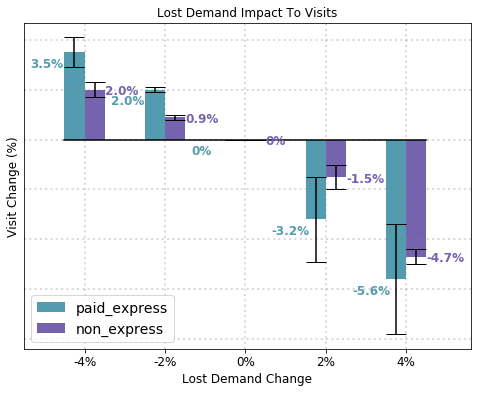

In [62]:
ld_list = [-4, -2, 0, 2, 4]
x1 = [i - 0.25 for i in ld_list]
x2 = [i + 0.25 for i in ld_list]
paid_express_change = [i * 1 for i in [3.5, 2.0, 0, -3.2, -5.6]]
paid_express_err = [i * 1 for i in [0.6, 0.1, 0, 1.7, 2.2]]

non_express_change = [i * 1 for i in [2.0, 0.9, 0, -1.5, -4.7]]
non_express_err = [i * 1 for i in [0.3, 0.1, 0, 0.5, 0.3]]

fig, ax = plt.subplots(figsize=(8,6))
ax.plot([i * 0.5 for i in range(-9, 10)], [0 for i in range(19)], color='black')
ax.bar(x1, paid_express_change, align='center', color='#539caf',\
       yerr=paid_express_err, capsize=10, width=0.5, label='paid_express')
ax.bar(x2, non_express_change, align='center', color='#7663b0',\
       yerr=non_express_err, capsize=10, width=0.5, label='non_express')
ax.set_ylabel('Visit Change (%)',fontsize=12)
ax.set_xlabel('Lost Demand Change',fontsize=12)
ax.set_title('Lost Demand Impact To Visits')
#ax.set_ylim([-18, 8])
ax.set_xlim([-5.5, 5.6])
ax.legend(loc = 'lower left',fontsize=14)
for i, v in enumerate(paid_express_change):
    ax.text(i*2 - 5.35, v - 0.6, str(v) + '%', color='#539caf', fontweight='bold', fontsize=12)
for i, v in enumerate(non_express_change):
    ax.text(i*2 - 3.5, v - 0.2, str(v) + '%', color='#7663b0', fontweight='bold', fontsize=12)
ax.grid(True, color='grey', linestyle=':', linewidth=2, alpha=0.3)
ax.set_xticklabels(('', '-4%', '-2%', '0%', '2%', '4%'), fontsize=12)
ax.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    left=False,      # ticks along the bottom edge are off
    right=False,         # ticks along the top edge are off
    labelbottom=False,
    labelleft=False) # labels along the bottom edge are off
plt.savefig(time_period + ' Lost Impact To Visits Final 6.0.0.1.png')
plt.show()